In [1]:
import numpy as np
import re
import random
import itertools
import datetime

import tensorflow as tf
import sklearn as sk
import colorama as col

from gensim.models import Word2Vec

import Functions as fn
from DS import DS
from Set import pool
from Iterator import Iterator
from FFModel import FF_Model

C:\Users\Luka\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Data Loading

In [2]:
Dataset = pool()
Dataset.load_texts('raw_texts')
Dataset.load_labels('raw_labels')

Raw Text Load Complete
Raw Labels Load Complete


In [3]:
target_dict = fn.load_labels('labels')

Label Load Complete


# Embedding Generation

In [4]:
#Dataset.process_for_embedding()
#sentences = Dataset.get_sentences()
#fn.write_sentences('sentences')
sentences = fn.load_sentences('sentences')

#model = Word2Vec(sentences, min_count=1, size=100)
#model.save('W2V')
model = Word2Vec.load('W2V')

vocab = model.wv.vocab.keys()

Sentence Load Complete


# FFNN Testing

In [5]:
train_cases = pool((Dataset.get_DS(stage='test', labelled='yes')).data[:-25])
validation_cases = pool(Dataset.get_DS(stage='test', labelled='yes').data[-25:])
test_cases = Dataset.get_DS(stage='train', labelled='yes')

train_cases.process_for_testing()
validation_cases.process_for_testing()
test_cases.process_for_testing()

In [6]:
sets = {}
sets['train_set'], sets['train_labels'], _ = train_cases.get_ff_sets(model)
sets['validation_set'], sets['validation_labels'], _ = validation_cases.get_ff_sets(model)
sets['test_set'], sets['test_labels'], sets['test_words'] = test_cases.get_ff_sets(model)

In [7]:
print('Ratio: med: {:.2f}% non-med: {:.2f}%'.format(*(np.array(sets['train_labels']).sum(0)/ len(sets['train_labels']))))
fn.saturate_training_set_training(sets['train_set'], sets['train_labels'], 0.1)
print('Ratio: med: {:.2f}% non-med: {:.2f}%'.format(*(np.array(sets['train_labels']).sum(0)/ len(sets['train_labels']))))

Ratio: med: 0.05% non-med: 0.95%
Ratio: med: 0.13% non-med: 0.87%


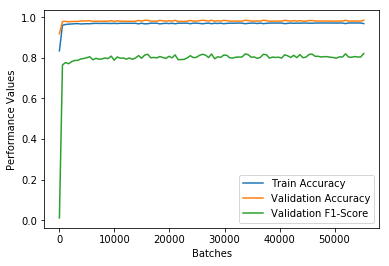

FInal Values: TrAcc: 0.9691, ValAcc: 0.9856, ValF1: 0.8215
Test F1-Score: 0.8560



In [8]:
NN = FF_Model(layers=[50])
NN.build_graph()
_,_,_,_ = NN.train(sets, epochs=10, batch=50, show_plot=True, show_progress=True)

In [9]:
res = NN.predict(sets['test_set'])
tru = np.argmax(sets['test_labels'], 1)

In [10]:
_ = fn.token_perf(res, tru)

TP	TN	FP	FN
434	10581	64	82

Precision: 0.8715
Recall: 0.8411
F1-Score: 0.8560


In [ ]:
baseline = [0 if word in target_dict['medications'] else 1 for word in sets['test_words']]
sk.metrics.f1_score(tru, baseline, pos_label=0, average='binary')

In [11]:
fn.category_words(sets['test_words'], res, tru, 0, 1)

codeine, rose-walt, tablets, sodium, potassium, chloride, magnesium, boluses, sodium, potassium, chloride, magnesium, nasal, inhibitor, tylenol, insulin, hep, micro, sedation, antibiotics, m/w/f, therapeutic, ischemia-mr, grana, aspirin, insulin, therapeutic, m/w/f, caffeine, morphine, sodium, potassium, chloride, calcium, magnesium, loading, iron, therapeutic, monday-wednesday-friday, flagyl, monday-wednesday-friday, monday-wednesday-friday, medication, rx, monday-wednesday-friday, monday-wednesday-friday, medication, penicillin, hcl, huyett, hydrate, riss, quinine, aspirin, <num>.<num>-<num>, aspirin, motrin, spray, sodium, aspirin, sprays, aspirin, ppi, iss


In [12]:
fn.colour_text(sets['test_words'], res, tru)

record #<num> <num> | tmh | <num> | | <num> | <num>/<num>/<num> <num>:<num>:<num> am | discharge summary | signed | dis | admission date <num>/<num>/<num> report status signed discharge date <num>/<num>/<num> history ms pizzo is a <num>-year-old woman with peripheral vascular disease who recently underwent revision of her left superior femoral artery anterior tibial bypass graft , who now presents with a cool , ischemic left foot mrs denman is a <num>-year-old , insulin-dependent diabetic with a long history of peripheral vascular disease as well as multiple surgical procedures she underwent a right transmetatarsal amputation in <num> and subsequently underwent a right femorla distal saphenous vein bypass graft in <num> which was later revised in <num>. she seems to be doing well with the left side until july of this year , at which time she underwent a left superficial femoral artery to anterior tibial artery bypass using non-reversed basilic vein harvested from the right arm she , ho

In [14]:
testers = Dataset.get_DS(stage='train', labelled='yes')
_ = fn.phrase_perf(NN, testers, model, case_info=True, show_phrases=True)

Name:  0101
Challenge:  2009 Medication Challenge
Train or Test Set:  train
Labelled:  yes
Labeling Type:  train


Result Medications:
antibiotics, lopressor, colace, insulin nph, rose-walt, percocet, isordil, codeine, tablets, zestril, insulin lente, axid, ecotrin, insulin, vancomycin, heparin, urokinase, ofloxacin, coumadin

True Medications:
antibiotics, lopressor, colace, insulin nph, percocet, isordil, heparin, zestril, axid, ecotrin, vancomycin, insulin, urokinase, insulin lente, ofloxacin, coumadin

Name:  0102
Challenge:  2009 Medication Challenge
Train or Test Set:  train
Labelled:  yes
Labeling Type:  train


Result Medications:
potassium, metformin, chloride, atenolol, sodium, motrin, magnesium, lantus, toprol-xl, potassium chloride slow release, lasix, insulin, novolog, nasal, precedex, aspirin, beta-blocker, humalog insulin, ciprofloxacin, epinephrine, boluses, baby aspirin

True Medications:
aspirin, toprol-xl, potassium chloride slow release, beta-blocker, metformin, hum

# HyperParameter Scan

In [ ]:
emb_num = 1
NN_num = 1
emb_sizes = [30, 50, 100]
target_saturations = [0.05, 0.1, 0.3]
layers = [[30], [50], [100]]
dropouts = [0.3, 0.5, 0.8, 1.0]
learn_rates = [0.001, 0.01, 0.1]
epoch_nums = [10, 50, 100]
batch_sizes = [10, 50, 100]


model_num = emb_num * NN_num * len(emb_sizes) * len(layers) * len(dropouts) * \
            len(learn_rates) * len(epoch_nums) * len(batch_sizes) * len(target_saturations)
target = target_dict['medications']
report_percentage = 10

print(model_num)

In [ ]:
labelled_cases = Dataset.get_DS(labelled='yes')
labelled_cases.process_for_testing()

In [ ]:
iterations = [emb_sizes, target_saturations, layers, dropouts, learn_rates, epoch_nums, batch_sizes]

In [ ]:
n = 0
parameters = []
results = []
timestamp = re.sub(r':', '-', str(datetime.datetime.now()).split('.')[0])

with open('tests/Model2/' + timestamp, 'w+') as f:
    print('EmbSz:\tSat:\tLay:\tDrop:\tLeRa:\tEpochs:\tBatSz:\tF1:')
    f.write('EmbSz:\tSat:\tLay:\tDrop:\tLeRa:\tEpochs:\tBatSz:\tF1:\n')
    for par in itertools.product(*iterations):
        best = 0
        parameters.append(par)
        for i in range(emb_num):
            model = Word2Vec(sentences, min_count=1, size=par[0])
            sets = fn.get_ff_traintest(labelled_cases, model)
            fn.saturate_training_set_labels(sets, model, target, par[1])
            for j in range(NN_num):
                n += 1
                print('Model Number: {}/{}'.format(n, model_num), end='\r')
                NN = FF_Model(input_size=par[0], layers=par[2], dropout=par[3], learn_rate=par[4])
                NN.build_graph()
                _, _, _, score = NN.train(sets, epochs=par[5], batch=par[6], report_percentage=report_percentage)
                best = max(best, score)
        results.append(best)
        print('{}\t{}\t{}\t{}\t{}\t{}\t{}\t{:.4f}'.format(*parameters[-1], results[-1]))
        f.write('{}\t{}\t{}\t{}\t{}\t{}\t{}\t{:.4f}\n'.format(*parameters[-1], results[-1]))

    print('Max Performance: {:.4f}'.format(max(results)))  
    f.write('Max Performance: {:.4f}\n'.format(max(results)))